In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
# 生成随机矩阵X_n
n = 1000    # 样本量
p = 1500    # 变量数

# 创建协方差矩阵
cov_matrix = np.full((p, p), 0.5)  # 创建一个所有元素都是 0.5 的矩阵
np.fill_diagonal(cov_matrix, 2.0)  # 将对角线元素设置为 2.0

mean_vector                = np.zeros(p)  # 均值向量
X                          = np.random.multivariate_normal(mean_vector, cov_matrix, n)
# 奇异值分解
U, S, Vt = np.linalg.svd(X)

# 计算条件数
condition_number = S[0] / S[-1]
print("条件数:", condition_number)


# 打印奇异值
S_adjusted = np.copy(S)
for i in range(len(S)):
        S_adjusted[i] /= 10**(0.00225*i)   # 或者选择其他缩放因子
        # S_adjusted[i] /= i+1   # 或者选择其他缩放因子
# print("奇异值:", S_adjusted) 
print("最大奇异值:", np.max(S_adjusted))
print("最小奇异值:", np.min(S_adjusted))
print("条件数:", np.max(S_adjusted)/np.min(S_adjusted))
Sigma = np.zeros((U.shape[0], Vt.shape[0]))
np.fill_diagonal(Sigma, S_adjusted)
X =  U @ Sigma @ Vt




条件数: 98.41678254019718
最大奇异值: 849.7927557847369
最小奇异值: 0.04880832025971307
条件数: 17410.817484865693


In [3]:
import numpy as np
import numpy as np

# 定义β向量
beta = np.zeros(p)  # 初始化β向量为0

# 根据条件设置β向量的值
beta[0:5]   = 2.0   # βi = 2.0, i = 1, 2, 3, 4, 5
beta[5:10]  = -2.0  # βi = -2.0, i = 6, 7, 8, 9, 10
beta[10:15] = 1.0   # βi = 1.0, i = 11, 12, 13, 14, 15
beta[15:20] = -1.0  # βi = -1.0, i = 16, 17, 18, 19, 20
# beta[20:25] = 5.0   # βi = 5.0, i = 21, 22, 23, 24, 25

# Generate 20 random indices
indices = np.random.randint(low=0, high=p, size=20)

# Get the indices of non-zero elements in beta
nonzero_indices = np.nonzero(beta)[0]

# print(nonzero_indices)

# 初始化random_beta为零向量
random_beta = np.zeros(p)

# Assign the non-zero elements randomly
# 此处假设的意图是将beta中的非零元素随机分配到random_beta中
# 但这样的操作逻辑上存在问题，因为indices的长度和nonzero_indices可能不同
# 为了简化，这里我们只是简单地复制beta到random_beta
random_beta[indices] = beta[nonzero_indices]

# Print the randomly assigned beta
# print(random_beta)
beta = random_beta
nonzero_indices = np.nonzero(beta)[0]
print(nonzero_indices)

[  17   60   97  180  301  320  584  659  734  746  847  886  922  964
 1006 1092 1146 1212 1247 1439]


In [4]:
# 生成均值为0方差为4的n维向量en
mean    = 0  # 均值
std_dev = 2  # 标准差，方差为标准差的平方，即4

# 生成向量
e = np.random.normal(mean, std_dev, n)
norm_e = np.linalg.norm(e)
Y = np.dot(X, beta) + e
print(norm_e)

61.0393294252701


In [5]:
from scipy.stats import laplace


# 生成Laplace分布的随机样本
el = laplace.rvs(loc=0, scale=np.sqrt(2), size=1000)
norm_e = np.linalg.norm(el)
Y = np.dot(X, beta) + el
print(norm_e)

62.658600495925285


In [6]:
tau   = 1
delta = tau*norm_e
# delta = 50

In [7]:
# 最小二乘法
def least_square(X, Y):
    beta = np.linalg.lstsq(X, Y, rcond=None)[0]
    return beta
beta_LS = least_square(X, Y)
norm_LS = np.linalg.norm(beta_LS - beta)
print(norm_LS)


252.38318491377456


In [8]:
# 岭回归
# alpha  = 1/s1**2
C = 1
def ridge(X, Y):
    s1, s2 = X.shape
    alpha  = C/s1
    I      = np.eye(s2)
    beta   = np.linalg.inv(X.T @ X + alpha*I) @ X.T @ Y
    beta_debias = (I + alpha*np.linalg.inv(X.T @ X + alpha*I))@beta
    return beta, beta_debias

beta_Ridge, beta_Ridge_debias = ridge(X, Y)
norm_Ridge = np.linalg.norm(beta_Ridge - beta)
norm_Ridge_debias = np.linalg.norm(beta_Ridge_debias - beta)
print(norm_Ridge, norm_Ridge_debias)




221.77764503147387 247.15924113950805


In [9]:
# Landweber回归
t        = 5e-7    # 步长
max_iter = 10000   # 最大迭代次数

def landweber(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        beta_cur = beta_prev + t * np.dot(X.T, (Y - np.dot(X, beta_prev)))
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        #if np.linalg.norm(beta_cur - beta_prev) <= 1e-4:
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k
def landweber_debias(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        beta_cur = beta_prev + t * np.dot(X.T, (Y - np.dot(X, beta_prev)))
        if k == max_iter:
            break
    return beta_cur
beta_Landweber, k_Landweber = landweber(X, Y, t, max_iter)
beta_Landweber_debias = landweber_debias(X, Y, t, 2*k_Landweber)
norm_Landweber    = np.linalg.norm(beta_Landweber - beta)
norm_Landweber_debias  = np.linalg.norm(beta_Landweber_debias - beta)  

print(norm_Landweber, k_Landweber, norm_Landweber_debias)



6.456021751099372 2459 6.3546469962593095


In [10]:
# Showalter回归
t        = 5e-7    # 步长
max_iter = 10000   # 最大迭代次数

def showalter(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    Z1 = np.dot(X.T, Y)
    Z2 = np.dot(X.T, X)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        K1 = Z1 - np.dot(Z2, beta_prev)
        K2 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K1))
        K3 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K2))
        K4 = Z1 - np.dot(Z2, (beta_prev + t * K3))
        beta_cur = beta_prev + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        # if np.linalg.norm(beta_cur - beta_prev) <= 1e-4:
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k
def showalter_debias(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    Z1 = np.dot(X.T, Y)
    Z2 = np.dot(X.T, X)
    for k in range(1, max_iter):
        beta_prev = beta_cur
        K1 = Z1 - np.dot(Z2, beta_prev)
        K2 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K1))
        K3 = Z1 - np.dot(Z2, (beta_prev + 0.5 * t * K2))
        K4 = Z1 - np.dot(Z2, (beta_prev + t * K3))
        beta_cur = beta_prev + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        if k == max_iter:
            break
    return beta_cur
beta_showalter, k_showalter = showalter(X, Y, t, max_iter)
beta_showalter_debias = showalter_debias(X, X@beta_showalter, t, k_showalter)
beta_showalter_debias = 2*beta_showalter-beta_showalter_debias
norm_showalter = np.linalg.norm(beta_showalter - beta)
norm_showalter_debias = np.linalg.norm(beta_showalter_debias - beta)
print(norm_showalter, k_showalter, norm_showalter_debias)

6.456036043566544 2459 6.354619883090367


In [11]:
# HBF回归
t        = 5e-4    # 步长
max_iter = 10000   # 最大迭代次数

def hbf(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    eta = 5

    A11 = np.zeros((m, m))
    A12 = np.eye(m)
    A21 = -np.dot(X.T, X)
    A22 = -eta * np.eye(m)
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))
    b = np.hstack((np.zeros(m), np.dot(X.T, Y)))
    z = np.zeros(2 * m)

    for k in range(1, max_iter):
        K1 = np.dot(A, z) + b
        K2 = np.dot(A, (z + 0.5 * t * K1)) + b
        K3 = np.dot(A, (z + 0.5 * t * K2)) + b
        K4 = np.dot(A, (z + t * K3)) + b
        z = z + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        beta_cur = z[:m]
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k

def hbf_debias(X, Y, t, max_iter):
    s = X.shape
    m = s[1]
    eta = 5

    A11 = np.zeros((m, m))
    A12 = np.eye(m)
    A21 = -np.dot(X.T, X)
    A22 = -eta * np.eye(m)
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))
    b = np.hstack((np.zeros(m), np.dot(X.T, Y)))
    z = np.zeros(2 * m)

    for k in range(1, max_iter):
        K1 = np.dot(A, z) + b
        K2 = np.dot(A, (z + 0.5 * t * K1)) + b
        K3 = np.dot(A, (z + 0.5 * t * K2)) + b
        K4 = np.dot(A, (z + t * K3)) + b
        z = z + t / 6 * (K1 + 2 * K2 + 2 * K3 + K4)
        beta_cur = z[:m]
        if k == max_iter:
            break
    return beta_cur
beta_hbf, k_hbf = hbf(X, Y, t, max_iter)
beta_hbf_debias = hbf_debias(X, X@beta_hbf, t, k_hbf)
beta_hbf_debias = 2*beta_hbf - beta_hbf_debias
norm_hbf = np.linalg.norm(beta_hbf - beta)
norm_hbf_debias = np.linalg.norm(beta_hbf_debias - beta)
print(norm_hbf, k_hbf, norm_hbf_debias)

KeyboardInterrupt: 

In [ ]:
# Acceleration regression of order kappa
t        = 5e-5   # 步长
max_iter = 10000   # 最大迭代次数
kappa    = 1.5       # 加速阶数

def ARk(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_prev = np.zeros(m)
    I      = np.eye(m)
    v_prev = np.zeros(m)
    for k in range(1, k_max):
        beta_cur = beta_prev + k*t*v_prev
        D = np.linalg.inv((t*(k*t)**kappa)*X.T @ X + I + (((k*t)**(-kappa))-kappa)/k*I)
        v_cur = D@v_prev+ t*D@np.dot(X.T, (Y - np.dot(X, beta_prev)))
        beta_prev = beta_cur
        v_prev = v_cur
        print(np.linalg.norm(Y - np.dot(X, beta_cur)),k)
        if np.linalg.norm(Y - np.dot(X, beta_prev)) <= delta:
            break
    return beta_cur, k

def ARk_debias(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_prev = np.zeros(m)
    I      = np.eye(m)
    v_prev = np.zeros(m)
    for k in range(1, k_max):
        beta_cur = beta_prev + k*t*v_prev
        D = np.linalg.inv((t*(k*t)**kappa)*X.T @ X + I + (((k*t)**(-kappa))-kappa)/k*I)
        v_cur = D@v_prev+t*D@np.dot(X.T, (Y - np.dot(X, beta_prev)))
        beta_prev = beta_cur
        v_prev = v_cur
        if k == max_iter:
            break
    return beta_cur    

beta_ARk, k_ARk = ARk(X, Y, t, max_iter)
beta_ARk_debias = ARk_debias(X, X@beta_ARk, t, k_ARk)
beta_ARk_debias = 2*beta_ARk - beta_ARk_debias
norm_ARk = np.linalg.norm(beta_ARk - beta)
norm_ARk_debias = np.linalg.norm(beta_ARk_debias - beta)
print(norm_ARk, k_ARk, norm_ARk_debias)

152.03581688304675 1
152.0358168813422 2
152.03581686687866 3
152.0358168137362 4
152.0358166773727 5
152.03581639151236 6
152.03581586543058 7
152.03581498151357 8
152.0358135930227 9
152.03581152201954 10
152.0358085574213 11
152.0358044531649 12
152.03579892646422 13
152.03579165614713 14
152.0357822810635 15
152.03577039855637 16
152.0357555629897 17
152.03573728432826 18
152.03571502676516 19
152.03568820739383 20
152.0356561949221 21
152.03561830842546 22
152.03557381613874 23
152.0355219342842 24
152.03546182593556 25
152.035392599917 26
152.03531330973726 27
152.0352229525583 28
152.0351204681993 29
152.03500473817599 30
152.03487458477622 31
152.03472877017296 32
152.03456599557524 33
152.03438490041893 34
152.03418406159878 35
152.03396199274323 36
152.03371714353432 37
152.03344789907447 38
152.03315257930268 39
152.03282943846253 40
152.03247666462468 41
152.03209237926689 42
152.03167463691403 43
152.03122142484216 44
152.03073066284898 45
152.0302002030951 46
152.02962783

In [ ]:
# 二阶渐进回归
t        = 5e-4    # 步长
max_iter = 10000   # 最大迭代次数

def second(X, Y, t, k_max):
    r = X.shape
    m = r[1]
    s = 0.5
    beta_cur = np.zeros(m)
    v_cur    = np.zeros(m)
    q_cur    = np.zeros(m)
    for k in range(1, k_max):
        p        =  2*k/(2*k+2*s+1)
        q_half   =  p*q_cur + p*(t / 2) * np.dot(X.T, (Y - np.dot(X, beta_cur))) 
        beta_cur = beta_cur + t * q_half
        a        = (2*k-2*s+1)*(k+1)/(2*k+2*s+3)/k
        v_cur   =  beta_cur + 2*t*a*q_half
        q_cur    =  (2*k+1-2*s)/(2*k+2)*q_half +(t / 2) * np.dot(X.T, (Y - np.dot(X, v_cur))) 
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k

def second_debias(X, Y, t, k_max):
    r = X.shape
    m = r[1]
    s = 0.5
    beta_cur = np.zeros(m)
    v_cur    = np.zeros(m)
    q_cur    = np.zeros(m)

    for k in range(1, k_max):
        p        =  2*k/(2*k+2*s+1)
        q_half   =  p*q_cur + p*(t / 2) * np.dot(X.T, (Y - np.dot(X, beta_cur))) 
        beta_cur = beta_cur + t * q_half
        a        = (2*k-2*s+1)*(k+1)/(2*k+2*s+3)/k
        v_cur   =  beta_cur + 2*t*a*q_half
        q_cur    =  (2*k+1-2*s)/(2*k+2)*q_half +(t / 2) * np.dot(X.T, (Y - np.dot(X, v_cur))) 
        if k == k_max:
            break
    return beta_cur

beta_second, k_second = second(X, Y, t, max_iter)
beta_second_debias = second_debias(X, X@beta_second, t, k_second)
beta_second_debias = 2*beta_second - beta_second_debias
norm_second = np.linalg.norm(beta_second - beta)
norm_second_debias = np.linalg.norm(beta_second_debias - beta)
print(norm_second, k_second, norm_second_debias)


6.466746916187839 168 6.363062460393024


In [ ]:
# Nesterov回归
t        = 5e-7    # 步长
max_iter = 10000   # 最大迭代次数
omega    = 3       # omega  

def Nesterov(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, k_max):
        beta_prev = beta_cur
        z_k = beta_cur + (k - 1) / (k + omega) * (beta_cur - beta_prev)
        XTX_z_k = np.dot(X.T, (Y - np.dot(X, z_k)))
        beta_cur = z_k + t * XTX_z_k
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)))
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k+1

def Nesterov_debias(X, Y, t, k_max):
    s = X.shape
    m = s[1]
    beta_cur = np.zeros(m)
    for k in range(1, k_max):
        beta_prev = beta_cur
        z_k = beta_cur + (k - 1) / (k + omega) * (beta_cur - beta_prev)
        XTX_z_k = np.dot(X.T, (Y - np.dot(X, z_k)))
        beta_cur = z_k + t * XTX_z_k
        if k == k_max:
            break
    return beta_cur

beta_Nesterov, k_Nesterov = Nesterov(X, Y, t, max_iter)
beta_Nesterov_debias = Nesterov_debias(X, X@beta_Nesterov, t, k_Nesterov)
beta_Nesterov_debias = 2*beta_Nesterov - beta_Nesterov_debias
norm_Nesterov = np.linalg.norm(beta_Nesterov - beta)
norm_Nesterov_debias = np.linalg.norm(beta_Nesterov_debias - beta)
print(norm_Nesterov, k_Nesterov, norm_Nesterov_debias)

6.470977968516816 2311 6.37127191816823


In [ ]:
from scipy.special import gamma

# 分数阶回归
t        = 5e-5     # 步长
max_iter = 500      # 最大迭代次数
theta    = 1.5       # theta
A        = np.zeros((max_iter+1, max_iter+1))
B        = np.zeros((max_iter, max_iter+1))
g        = 1/gamma(theta)
k1       = t**(theta)/(theta*(theta+1))
k2       = t**(theta)/theta

for k in range(max_iter):
    for j in range(k+2):
        if j == 0:
            d = k**(theta+1)-(k-theta)*(k+1)**(theta)
            A[j, k+1] = k1*d
        elif j < k+1:
            d = (k-j+2)**(theta+1)+(k-j)**(theta+1)-2*(k-j+1)**(theta+1)
            A[j, k+1] = k1*d
        elif j == k+1:
            A[j, k+1] = k1 
    for i in range(k+1):
        if i < k+1:
            d = (k-i+1)**theta-(k-i)**theta  
            B[i, k+1] = k2*d


def Frac(X, Y, k_max):
    s  = X.shape
    m  = s[1]
    b  = np.zeros((m, k_max+1))  
    bp = np.zeros((m, k_max+1))
    for k in range(1, k_max):
        bp[:, k+1] = g*sum([B[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1,k+1)]) 
        b[:, k+1]  = g*(A[k+1, k+1]*np.dot(X.T, (Y - np.dot(X, bp[:,k+1])))+sum([A[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1, k+1)]))
        beta_cur   = b[:, k+1]
        # print(np.linalg.norm(Y - np.dot(X, beta_cur)), k)
        if np.linalg.norm(Y - np.dot(X, beta_cur)) <= delta:
            break
    return beta_cur, k
def Frac_debias(X, Y, k_max):
    s  = X.shape
    m  = s[1]
    b  = np.zeros((m, k_max+1))  
    bp = np.zeros((m, k_max+1))
    for k in range(1, k_max):
        bp[:, k+1] = g*sum([B[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1,k+1)]) 
        b[:, k+1]  = g*(A[k+1, k+1]*np.dot(X.T, (Y - np.dot(X, bp[:,k+1])))+sum([A[j, k+1]*np.dot(X.T, (Y - np.dot(X, b[:,j]))) for j in range(1, k+1)]))
        beta_cur   = b[:, k+1]
        if k == k_max:
            break
    return beta_cur

beta_Frac, k_Frac = Frac(X, Y, max_iter)
beta_Frac_debias = Frac_debias(X, X@beta_Frac, k_Frac)
beta_Frac_debias = 2*beta_Frac - beta_Frac_debias
norm_Frac = np.linalg.norm(beta_Frac - beta)
norm_Frac_debias = np.linalg.norm(beta_Frac_debias - beta)
print(norm_Frac, k_Frac, norm_Frac_debias)


6.444220030154544 321 6.332597500725344


In [ ]:

import pandas as pd

results = []

for i in range(1, 1001):
    bn = 0.001 * i

    # 最小二乘法
    beta_LS[np.abs(beta_LS) < bn] = 0
    norm_LSbn = np.linalg.norm(beta_LS - beta)

    # 岭回归
    beta_Ridge[np.abs(beta_Ridge) < bn] = 0
    beta_Ridge_debias[np.abs(beta_Ridge_debias) < bn] = 0
    norm_Ridgebn = np.linalg.norm(beta_Ridge - beta)
    norm_Ridge_debiasbn = np.linalg.norm(beta_Ridge_debias - beta)

    # Landweber回归
    beta_Landweber[np.abs(beta_Landweber) < bn] = 0
    beta_Landweber_debias[np.abs(beta_Landweber_debias) < bn] = 0
    norm_Landweberbn = np.linalg.norm(beta_Landweber - beta)
    norm_Landweber_debiasbn = np.linalg.norm(beta_Landweber_debias - beta)

    # Showalter回归
    beta_showalter[np.abs(beta_showalter) < bn] = 0
    beta_showalter_debias[np.abs(beta_showalter_debias) < bn] = 0
    norm_showalterbn = np.linalg.norm(beta_showalter - beta)
    norm_showalter_debiasbn = np.linalg.norm(beta_showalter_debias - beta)


    # HBF回归
    beta_hbf[np.abs(beta_hbf) < bn] = 0
    beta_hbf_debias[np.abs(beta_hbf_debias) < bn] = 0
    norm_hbfbn = np.linalg.norm(beta_hbf - beta)
    norm_hbf_debiasbn = np.linalg.norm(beta_hbf_debias - beta)

    # Acceleration regression of order kappa
    beta_ARk[np.abs(beta_ARk) < bn] = 0
    beta_ARk_debias[np.abs(beta_ARk_debias) < bn] = 0
    norm_ARkbn = np.linalg.norm(beta_ARk - beta)
    norm_ARk_debiasbn = np.linalg.norm(beta_ARk_debias - beta)

    # 二阶渐进回归
    beta_second[np.abs(beta_second) < bn] = 0
    beta_second_debias[np.abs(beta_second_debias) < bn] = 0
    norm_secondbn = np.linalg.norm(beta_second - beta)
    norm_second_debiasbn = np.linalg.norm(beta_second_debias - beta)


    # Nesterov回归
    beta_Nesterov[np.abs(beta_Nesterov) < bn] = 0
    beta_Nesterov_debias[np.abs(beta_Nesterov_debias) < bn] = 0
    norm_Nesterovbn = np.linalg.norm(beta_Nesterov - beta)
    norm_Nesterov_debiasbn = np.linalg.norm(beta_Nesterov_debias - beta)

    # 分数阶回归
    beta_Frac[np.abs(beta_Frac) < bn] = 0
    beta_Frac_debias[np.abs(beta_Frac_debias) < bn] = 0
    norm_Fracbn = np.linalg.norm(beta_Frac - beta)
    norm_Frac_debiasbn = np.linalg.norm(beta_Frac_debias - beta)

    results.append([bn, norm_LSbn, norm_Ridgebn, norm_Ridge_debiasbn, norm_Landweberbn, norm_Landweber_debiasbn, norm_showalterbn, norm_showalter_debiasbn, norm_hbfbn, norm_hbf_debiasbn, norm_ARkbn, norm_ARk_debiasbn, norm_secondbn, norm_second_debiasbn, norm_Nesterovbn, norm_Nesterov_debiasbn, norm_Fracbn, norm_Frac_debiasbn])

df = pd.DataFrame(results, columns=['bn', 'norm_LSbn', 'norm_Ridgebn', 'norm_Ridge_debiasbn', 'norm_Landweberbn', 'norm_Landweber_debiasbn', 'norm_showalterbn', 'norm_showalter_debiasbn', 'norm_hbfbn', 'norm_hbf_debiasbn', 'norm_ARkbn', 'norm_ARk_debiasbn', 'norm_secondbn', 'norm_second_debiasbn', 'norm_Nesterovbn', 'norm_Nesterov_debiasbn', 'norm_Fracbn', 'norm_Frac_debiasbn'])
df.to_csv('output.csv', index=False)





In [ ]:
results = []

# 遍历每一列，除了第一列'bn'
for column in df.columns[1:]:
    # 找到当前列的最小值
    min_val = df[column].min()
    # 找到所有最小值的索引
    min_indices = np.where(df[column] == min_val)[0]
    # 检查最小值是否相邻，并计算平均索引
    if len(min_indices) > 1 and np.all(np.diff(min_indices) == 1):
        # 如果最小值相邻，计算平均索引
        avg_index = np.mean(min_indices)
    else:
        # 如果只有一个最小值或最小值不相邻，直接使用找到的索引
        avg_index = min_indices[0]
    # 将结果添加到列表中（乘以0.001以匹配您的需求）
    results.append([min_val, avg_index * 0.001])

# 将结果转换为numpy数组
results_array = np.array(results)

# 打印结果以验证
print(results_array)

[[2.23650582e+02 9.99000000e-01]
 [1.94669178e+02 9.98500000e-01]
 [2.17952802e+02 9.97500000e-01]
 [6.15804947e+00 1.39000000e-01]
 [5.91950011e+00 1.77000000e-01]
 [6.15797726e+00 1.39000000e-01]
 [5.91925518e+00 1.77000000e-01]
 [5.17696240e+00 4.17500000e-01]
 [5.46042218e+00 4.49500000e-01]
 [6.15487737e+00 1.40000000e-01]
 [5.91781319e+00 1.77500000e-01]
 [6.03391849e+00 1.64000000e-01]
 [5.88065487e+00 1.84000000e-01]
 [6.15804947e+00 1.39000000e-01]
 [5.91942991e+00 1.77000000e-01]
 [5.88726495e+00 1.88500000e-01]
 [5.81174480e+00 1.91000000e-01]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


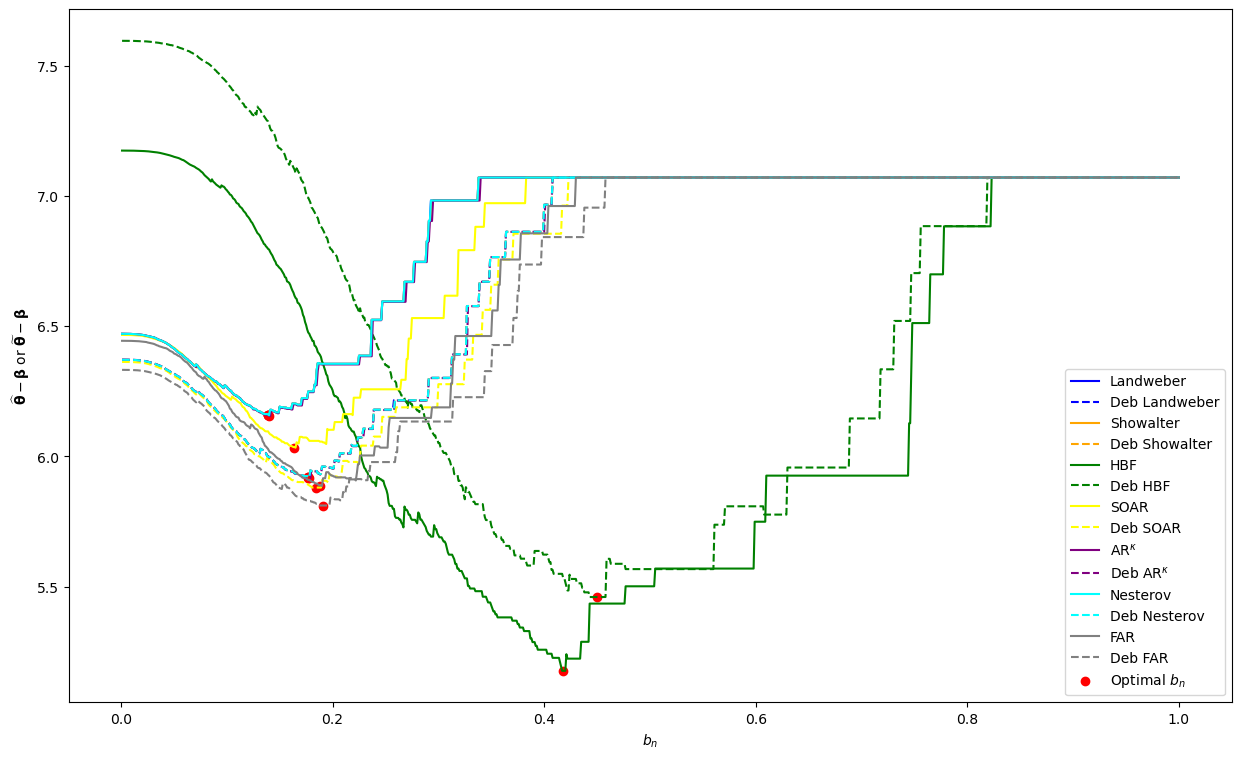

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
# 画图
import matplotlib.pyplot as plt



plt.figure(figsize=(15, 9))
# plt.plot(df['bn'], df['norm_LSbn'], label='LS', color='gold', linestyle='-')
# plt.plot(df['bn'], df['norm_Ridgebn'], label='Ridge', color='black',linestyle='-')
# plt.plot(df['bn'], df['norm_Ridge_debiasbn'], label='Deb Ridge', color='black',linestyle='--')
plt.plot(df['bn'], df['norm_Landweberbn'], label='Landweber', color='blue', linestyle='-')
plt.plot(df['bn'], df['norm_Landweber_debiasbn'], label='Deb Landweber', color='blue',linestyle='--')
plt.plot(df['bn'], df['norm_showalterbn'], label='Showalter', color='orange', linestyle='-')
plt.plot(df['bn'], df['norm_showalter_debiasbn'], label='Deb Showalter', color='orange', linestyle='--')
plt.plot(df['bn'], df['norm_hbfbn'], label='HBF', color='green', linestyle='-')
plt.plot(df['bn'], df['norm_hbf_debiasbn'], label='Deb HBF', color='green', linestyle='--')
plt.plot(df['bn'], df['norm_secondbn'], label='SOAR', color='yellow', linestyle='-')
plt.plot(df['bn'], df['norm_second_debiasbn'], label='Deb SOAR', color='yellow', linestyle='--')
plt.plot(df['bn'], df['norm_ARkbn'], label=r'AR$^\kappa$', color='purple', linestyle='-')
plt.plot(df['bn'], df['norm_ARk_debiasbn'], label=r'Deb AR$^\kappa$', color='purple', linestyle='--')
plt.plot(df['bn'], df['norm_Nesterovbn'], label='Nesterov', color='cyan', linestyle='-')
plt.plot(df['bn'], df['norm_Nesterov_debiasbn'], label='Deb Nesterov', color='cyan', linestyle='--')
plt.plot(df['bn'], df['norm_Fracbn'], label='FAR', color='gray', linestyle='-')
plt.plot(df['bn'], df['norm_Frac_debiasbn'], label='Deb FAR', color='gray', linestyle='--')
plt.xlabel(r'$b_n$')
plt.ylabel(r'$\widehat{\mathbf{\theta}}-\mathbf{\beta}$ or $\widetilde{\mathbf{\theta}}-\mathbf{\beta}$')
# 假设 df 是已经定义并包含必要数据的 pandas 数据框
plt.scatter(results_array[3:, 1], results_array[3:, 0], color='red', label=r'Optimal $b_n$') 
plt.legend()
# plt.legend(loc='upper left')
# plt.savefig('Laplace05.eps', format='eps')
# plt.savefig('Normal05.eps', format='eps')
# plt.savefig('PartLaplace10.eps', format='eps')
# plt.savefig('Laplace10.eps', format='eps')
# plt.savefig('Normal10.eps', format='eps')
# plt.savefig('PartNormal10.eps', format='eps')
plt.savefig('Laplace15.eps', format='eps')
# plt.savefig('Normal15.eps', format='eps')
# 显示图例
plt.show()



In [ ]:
print(f"LS                   & {norm_LS:.6f} &  ~    &  ~           & {results_array[0, 0]:.6f} &   ~        & {results_array[0, 1]:.4f} & ~      \\\\")
print(f"Ridge                & {norm_Ridge:.6f} &  ~    &  {norm_Ridge_debias:.6f}  & {results_array[1, 0]:.6f} & {results_array[2, 0]:.6f} & {results_array[1, 1]:.4f} & {results_array[2, 1]:.4f} \\\\")
print(f"Landweber            & {norm_Landweber:.6f}   &  {k_Landweber} &  {norm_Landweber_debias:.6f}    & {results_array[3, 0]:.6f}   & {results_array[4, 0]:.6f}   & {results_array[3, 1]:.4f} & {results_array[4, 1]:.4f} \\\\")
print(f"Showalter            & {norm_showalter:.6f}   &  {k_showalter} &  {norm_showalter_debias:.6f}    & {results_array[5, 0]:.6f}   & {results_array[6, 0]:.6f}   & {results_array[5, 1]:.4f} & {results_array[6, 1]:.4f} \\\\")
print(f"HBF                  & {norm_hbf:.6f}   &  {k_hbf}  &  {norm_hbf_debias:.6f}    & {results_array[7, 0]:.6f}   & {results_array[8, 0]:.6f}   & {results_array[7, 1]:.4f} & {results_array[8, 1]:.4f} \\\\")
print(f"$\\textrmAR^\\kappa$ & {norm_ARk:.6f}   &  {k_ARk}  &  {norm_ARk_debias:.6f}    & {results_array[9, 0]:.6f}   & {results_array[10, 0]:.6f}   & {results_array[9, 1]:.4f} & {results_array[10, 1]:.4f} \\\\")
print(f"SOAR                 & {norm_second:.6f}   &  {k_second}  &  {norm_second_debias:.6f}    & {results_array[11, 0]:.6f}   & {results_array[12, 0]:.6f}   & {results_array[11, 1]:.4f} & {results_array[12, 1]:.4f} \\\\")
print(f"Nesterov             & {norm_Nesterov:.6f}   &  {k_Nesterov} &  {norm_Nesterov_debias:.6f}    & {results_array[13, 0]:.6f}   & {results_array[14, 0]:.6f}   & {results_array[13, 1]:.4f} & {results_array[14, 1]:.4f} \\\\")
print(f"FAR                  & {norm_Frac:.6f}   &  {k_Frac}  &  {norm_Frac_debias:.6f}    & {results_array[15, 0]:.6f}   & {results_array[16, 0]:.6f}   & {results_array[15, 1]:.4f} & {results_array[16, 1]:.4f} \\\\   \\hline")



LS                   & 223.812658 &  ~    &  ~           & 223.650582 &   ~        & 0.9990 & ~      \\
Ridge                & 194.871093 &  ~    &  218.127748  & 194.669178 & 217.952802 & 0.9985 & 0.9975 \\
Landweber            & 6.470978   &  2310 &  6.371300    & 6.158049   & 5.919500   & 0.1390 & 0.1770 \\
Showalter            & 6.470924   &  2311 &  6.371217    & 6.157977   & 5.919255   & 0.1390 & 0.1770 \\
HBF                  & 7.174594   &  640  &  7.596059    & 5.176962   & 5.460422   & 0.4175 & 0.4495 \\
$\textrmAR^\kappa$ & 6.470976   &  688  &  6.371733    & 6.154877   & 5.917813   & 0.1400 & 0.1775 \\
SOAR                 & 6.466747   &  168  &  6.363062    & 6.033918   & 5.880655   & 0.1640 & 0.1840 \\
Nesterov             & 6.470978   &  2311 &  6.371272    & 6.158049   & 5.919430   & 0.1390 & 0.1770 \\
FAR                  & 6.444220   &  321  &  6.332598    & 5.887265   & 5.811745   & 0.1885 & 0.1910 \\   \hline
